In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
# def analysis(col):
#     temp = train[col].value_counts()
#     temp = temp[temp > temp.iloc[0]//100].index
#     temp_df = train[train[col].isin(temp)]
#     #temp_df = temp_df.sample(1000)
#     p = temp_df.HasDetections.mean()
#     q = 1-p
#     random_data = pd.Series(np.random.choice([1,0], len(temp_df),p=[p,q]), index = temp_df.index).rename('HasDetections')
#     temp_df['random_data'] = random_data
    
#     #temp_df.groupby(col).HasDetections.mean().plot(kind = 'bar', figsize=(20,10))
#     temp_df.groupby(col)[['HasDetections', 'random_data']].mean().plot(kind = 'bar', figsize=(20,10))
#     plt.title('Percent of Has detections by {}'.format(col))
    
#     display(pd.DataFrame({'train_data': temp_df.groupby(col).HasDetections.mean(),
#                          'random_data': temp_df.groupby(col).random_data.mean()}))
#     return stats.chi2_contingency([temp_df.groupby(col).HasDetections.mean(),
#                 temp_df.groupby(col).random_data.mean()])
def analysis(col, tops = 10):
    temp = train[col].value_counts()
    temp = temp.iloc[:tops].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
    prob = temp_df[col].value_counts(normalize=True)
    draw = np.random.choice(prob.index, p=prob, size=len(temp_df))
    output = pd.Series(draw).value_counts(normalize=True).rename('simulated')
    zeros = set(temp_df[col].dropna().unique()).difference(set(output.index))
    output = output.append(pd.Series([0 for i in zeros], index = zeros))
    pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                         'random_data': output}).plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                         'random_data': output}))
    return stats.ks_2samp(temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                output)
                        

In [3]:
COLS = [
    'HasDetections',
    'Platform',
    'OsBuild'
]

In [4]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [5]:
train.head()

,Platform,OsBuild,HasDetections
0,windows10,17134,0
1,windows10,17134,0
2,windows10,17134,0
3,windows10,17134,1
4,windows10,17134,1


,train_data,random_data
windows10,0.966525,0.966000
windows8,0.022104,0.021844
windows7,0.010244,0.010571
windows2016,0.001127,0.001585


Ks_2sampResult(statistic=0.25, pvalue=0.9968756885202121)

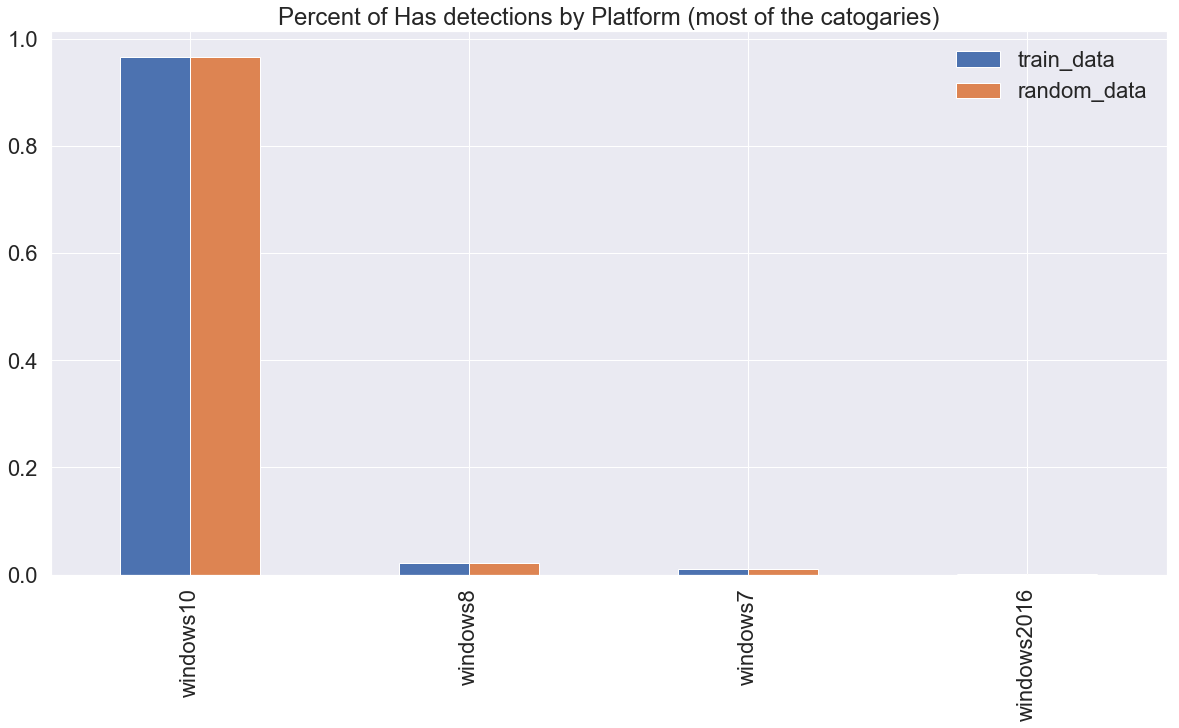

In [6]:
analysis(COLS[1])

In [7]:
# virius and platform is not likely revelent

,train_data,random_data
17134,0.457956,0.439805
16299,0.276746,0.281124
15063,0.083925,0.087629
14393,0.075880,0.082111
10586,0.043066,0.046124
10240,0.029529,0.030252
9600,0.022138,0.021847
7601,0.010194,0.010466
17692,0.000317,0.000359
17738,0.000248,0.000284


Ks_2sampResult(statistic=0.10000000000000009, pvalue=0.9999999942894181)

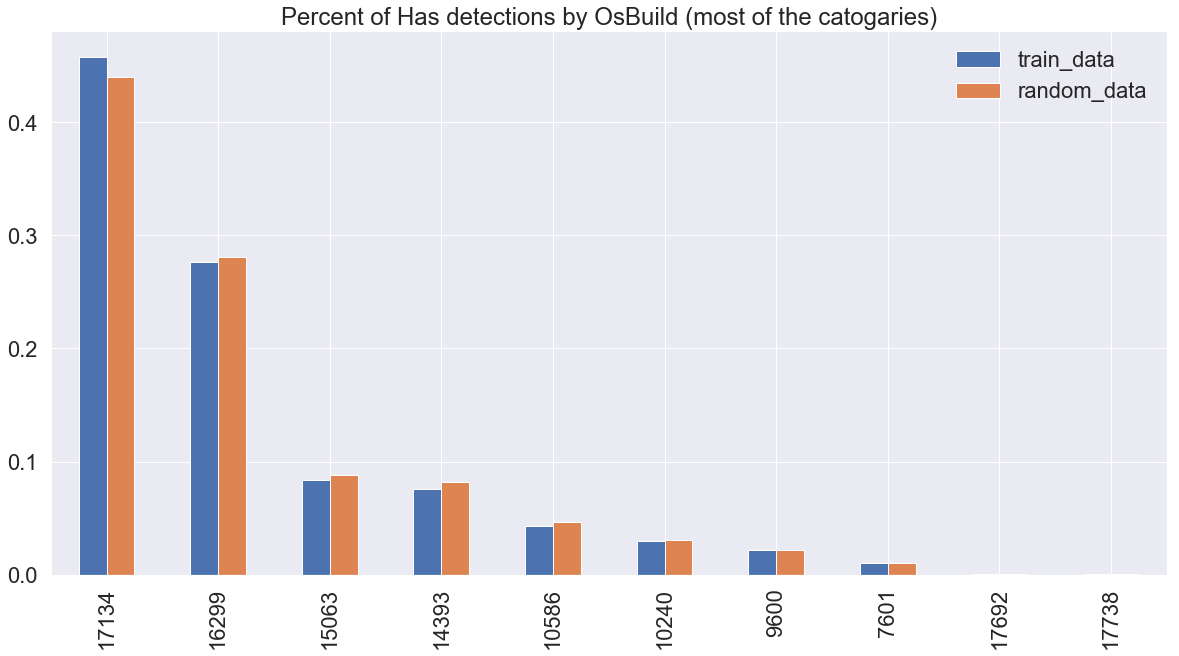

In [8]:
analysis(COLS[2])